# Day 1
---

> '계절 별로 풍력발전기의 발전량은 다를 것이다.' 라는 가설을 바탕으로 제주도에너지공사에서 운영하는 풍력발전기의 발전량을 예측할 것이다.<br>
- 발전량을 예측하는 것이므로 회귀 문제로 접근한다.
- 타겟은 풍력발전기의 발전량이다.
- 계절은 봄 : 3,4,5월 / 여름 : 6,7,8월 / 가을 : 9,10,11월 / 겨울 : 12,1,2월 로 나눈다.

> 필요한 데이터<br>
- 제주도의 기상상황 데이터 : 기상청 기상자료개방포털 데이터
- 제주에너지공사가 운영하는 풍력발전기의 발전량 데이터
<br>(*기상상황 데이터와 풍력발전기 발전량 데이터의 시간이 일치해야 함*)

> 얻을 수 있는 인사이트
- 풍력발전 예측이 정확하면 풍력발전의 불확실성에 기인한 재정적 및 기술적 위험도를 감소시켜준다.
- 가설을 통해 보다 정확한 발전량 예측이 가능할 것이다.

---

## 제주도의 기상 데이터 파악

In [370]:
# for Ridge, Lasso normalize=True options
# 해당 라이브러리 설치 후 런타임 다시 시작 -> 이후 셀 진행
!pip install scikit-learn==1.1.3

# geopandas를 사용하기 위한 설치 과정
!apt install libspatialindex-dev
!pip install rtree
!pip install geopandas

# 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-dev is already the newest version (1.9.3-1build1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: cach

In [371]:
# 데이터를 효율적으로 불러오기 위한 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [372]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'

- 기상청에서 19년 1월부터 22년 12월까지의 제주도 기상 정보를 일단위로 나타낸 데이터를 불러온다.

In [373]:
# 제주시 기상정보(북쪽)
weather184 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/weather/SURFACE_ASOS_184_DAY_2022_2022_2023.csv', encoding='CP949')
weather184_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/weather/SURFACE_ASOS_184_DAY_2021_2021_2022.csv', encoding='CP949')
weather184_2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/weather/SURFACE_ASOS_184_DAY_2020_2020_2021.csv', encoding='CP949')
weather184_3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/weather/SURFACE_ASOS_184_DAY_2019_2019_2020.csv', encoding='CP949')
weather184_4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/weather/SURFACE_ASOS_184_DAY_2018_2018_2019.csv', encoding='CP949')
weather184_4.rename(columns={'합계 일조 시간(hr)':'합계 일조시간(hr)','합계 일사(MJ/m2)':'합계 일사량(MJ/m2)'}, inplace=True)
weather_n = pd.concat([weather184_4, weather184_3, weather184_2, weather184_1, weather184]).reset_index(drop=True).drop('지점', axis=1)

# 고산 기상정보(서쪽)
weather185 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/weather/SURFACE_ASOS_185_DAY_2022_2022_2023.csv', encoding='CP949')
weather185_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/weather/SURFACE_ASOS_185_DAY_2021_2021_2022.csv', encoding='CP949')
weather185_2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/weather/SURFACE_ASOS_185_DAY_2020_2020_2021.csv', encoding='CP949')
weather185_3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/weather/SURFACE_ASOS_185_DAY_2019_2019_2020.csv', encoding='CP949')
weather185_4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/weather/SURFACE_ASOS_185_DAY_2018_2018_2019.csv', encoding='CP949')
weather185_4.rename(columns={'합계 일조 시간(hr)':'합계 일조시간(hr)','합계 일사(MJ/m2)':'합계 일사량(MJ/m2)'}, inplace=True)
weather_w = pd.concat([weather185_4, weather185_3, weather185_2, weather185_1, weather185]).reset_index(drop=True).drop('지점', axis=1)

# 성산 기상정보(동쪽)
weather188 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/weather/SURFACE_ASOS_188_DAY_2022_2022_2023.csv', encoding='CP949')
weather188_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/weather/SURFACE_ASOS_188_DAY_2021_2021_2022.csv', encoding='CP949')
weather188_2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/weather/SURFACE_ASOS_188_DAY_2020_2020_2021.csv', encoding='CP949')
weather188_3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/weather/SURFACE_ASOS_188_DAY_2019_2019_2020.csv', encoding='CP949')
weather188_4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/weather/SURFACE_ASOS_188_DAY_2018_2018_2019.csv', encoding='CP949')
weather188_4.rename(columns={'합계 일조 시간(hr)':'합계 일조시간(hr)','합계 일사(MJ/m2)':'합계 일사량(MJ/m2)'}, inplace=True)
weather_e = pd.concat([weather188_4, weather188_3, weather188_2, weather188_1, weather188]).reset_index(drop=True).drop('지점', axis=1)

# 서귀포 기상정보(남쪽)
weather189 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/weather/SURFACE_ASOS_189_DAY_2022_2022_2023.csv', encoding='CP949')
weather189_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/weather/SURFACE_ASOS_189_DAY_2021_2021_2022.csv', encoding='CP949')
weather189_2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/weather/SURFACE_ASOS_189_DAY_2020_2020_2021.csv', encoding='CP949')
weather189_3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/weather/SURFACE_ASOS_189_DAY_2019_2019_2020.csv', encoding='CP949')
weather189_4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/weather/SURFACE_ASOS_189_DAY_2018_2018_2019.csv', encoding='CP949')
weather189_4.rename(columns={'합계 일조 시간(hr)':'합계 일조시간(hr)','합계 일사(MJ/m2)':'합계 일사량(MJ/m2)'}, inplace=True)
weather_s = pd.concat([weather189_4, weather189_3, weather189_2, weather189_1, weather189]).reset_index(drop=True).drop('지점', axis=1)

- 기상 정보는 동/서/남/북으로 나뉘어 각각 성산, 고산, 서귀포, 제주시에서 관측된 자료들이 있었다.

In [374]:
# 시각에 대한 정보는 네자리로 12:00의 형태를 그대로 ':'없이 적은 것이다.
# 발전량을 일(日)단위로 예측할 것이므로 시각에 대한 데이터는 삭제해도 무방할 것으로 판단하였다.
drop_columns = weather_n.columns[weather_n.columns.str.contains('시각')].tolist()
weather_n = weather_n.drop(drop_columns, axis=1)
weather_e = weather_e.drop(drop_columns, axis=1)
weather_w = weather_w.drop(drop_columns, axis=1)
weather_s = weather_s.drop(drop_columns, axis=1)

In [375]:
print(weather_n.columns[weather_n.isnull().sum() == 1826].shape)
print(weather_e.columns[weather_e.isnull().sum() == 1826].shape)
print(weather_w.columns[weather_w.isnull().sum() == 1826].shape)
print(weather_s.columns[weather_s.isnull().sum() == 1826].shape)
# 모든 값이 결측치인 항목이 무엇인지 확인해 본다.
print(weather_e.columns[weather_e.isnull().sum() == 1826])
print(weather_w.columns[weather_w.isnull().sum() == 1826])
print(weather_s.columns[weather_s.isnull().sum() == 1826])
weather_e.columns[weather_e.isnull().sum() == 1826] == weather_w.columns[weather_w.isnull().sum() == 1826]
# weather_n의 결측치들은 대부분 비나 눈에 영향을 받는 값이므로 결측치를 0으로 채워주도록 한다.
# weather_e와 weather_w의 결측치 항목은 같다.
# weather_e/w : '강수 계속시간(hr)', '일 최심신적설(cm)', '일 최심적설(cm)', '합계 3시간 신적설(cm)', '9-9강수(mm)', '안개 계속시간(hr)'
# weather_s : '1시간 최다일사량(MJ/m2)', '합계 일사량(MJ/m2)', '합계 대형증발량(mm)', '합계 소형증발량(mm)'
# 공통 : '평균 5cm 지중온도(°C)', '평균 10cm 지중온도(°C)', '평균 20cm 지중온도(°C)',
      #  '평균 30cm 지중온도(°C)', '0.5m 지중온도(°C)', '1.0m 지중온도(°C)', '1.5m 지중온도(°C)',
      #  '3.0m 지중온도(°C)', '5.0m 지중온도(°C)',

# 공통 결측치 항목은 온도이기 때문에 모든 0으로 처리한다면 값의 오류가 생길 것이이고 채워주기엔 그 수가 너무 많으므로 삭제해 준다.
# weather_e/w/s의 결측치는 다른 지역들의 평균치를 넣어주도록 한다.

(0,)
(15,)
(15,)
(13,)
Index(['강수 계속시간(hr)', '일 최심신적설(cm)', '일 최심적설(cm)', '합계 3시간 신적설(cm)',
       '평균 5cm 지중온도(°C)', '평균 10cm 지중온도(°C)', '평균 20cm 지중온도(°C)',
       '평균 30cm 지중온도(°C)', '0.5m 지중온도(°C)', '1.0m 지중온도(°C)', '1.5m 지중온도(°C)',
       '3.0m 지중온도(°C)', '5.0m 지중온도(°C)', '9-9강수(mm)', '안개 계속시간(hr)'],
      dtype='object')
Index(['강수 계속시간(hr)', '일 최심신적설(cm)', '일 최심적설(cm)', '합계 3시간 신적설(cm)',
       '평균 5cm 지중온도(°C)', '평균 10cm 지중온도(°C)', '평균 20cm 지중온도(°C)',
       '평균 30cm 지중온도(°C)', '0.5m 지중온도(°C)', '1.0m 지중온도(°C)', '1.5m 지중온도(°C)',
       '3.0m 지중온도(°C)', '5.0m 지중온도(°C)', '9-9강수(mm)', '안개 계속시간(hr)'],
      dtype='object')
Index(['1시간 최다일사량(MJ/m2)', '합계 일사량(MJ/m2)', '평균 5cm 지중온도(°C)',
       '평균 10cm 지중온도(°C)', '평균 20cm 지중온도(°C)', '평균 30cm 지중온도(°C)',
       '0.5m 지중온도(°C)', '1.0m 지중온도(°C)', '1.5m 지중온도(°C)', '3.0m 지중온도(°C)',
       '5.0m 지중온도(°C)', '합계 대형증발량(mm)', '합계 소형증발량(mm)'],
      dtype='object')


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [376]:
# 공통 결측치 항목 삭제
drop_columns = ['평균 5cm 지중온도(°C)', '평균 10cm 지중온도(°C)', '평균 20cm 지중온도(°C)',
       '평균 30cm 지중온도(°C)', '0.5m 지중온도(°C)', '1.0m 지중온도(°C)', '1.5m 지중온도(°C)',
       '3.0m 지중온도(°C)', '5.0m 지중온도(°C)']
weather_list=[weather_n, weather_e, weather_w, weather_s]
for i in weather_list:
  i.drop(drop_columns, axis=1, inplace=True)

# weather_n의 결측치 모두 처리리
weather_n['합계 소형증발량(mm)'] = weather_n['합계 소형증발량(mm)'].fillna(weather_n['합계 소형증발량(mm)'].min())
weather_n['합계 대형증발량(mm)'] = weather_n['합계 대형증발량(mm)'].fillna(weather_n['합계 대형증발량(mm)'].min())
weather_n = weather_n.fillna(0)

# 바람과 관련된 항목 결측치는 각 데이터의 최소값을 넣어주었다.
columns_wind = weather_n.columns[weather_n.columns.str.contains('풍')]
for i in weather_list[1:]:
  for k in columns_wind:
    i[k] = i[k].fillna(i[k].min())

for i in weather_list[1:]:
  for k in weather_e.columns[14:24]:
    i[k] = i[k].fillna(method='ffill')

columns_wind = weather_n.columns[weather_n.columns.str.contains('강수')]
for i in weather_list[1:]:
  for k in columns_wind:
    i[k] = i[k].fillna(0)

weather_w['평균기온(°C)'] = weather_w['평균기온(°C)'].fillna(method='ffill')
weather_s['평균기온(°C)'] = weather_s['평균기온(°C)'].fillna(method='ffill')
weather_w['최저 초상온도(°C)'] = weather_w['최저 초상온도(°C)'].fillna(method='ffill')
weather_w['합계 대형증발량(mm)'] = weather_w['합계 대형증발량(mm)'].fillna(weather_w['합계 대형증발량(mm)'].min())
weather_w['합계 소형증발량(mm)'] = weather_w['합계 소형증발량(mm)'].fillna(weather_w['합계 소형증발량(mm)'].min())

for i in weather_list[1:]:
  for k in ['안개 계속시간(hr)','평균 전운량(1/10)','평균 중하층운량(1/10)','일 최심신적설(cm)','일 최심적설(cm)','일 최심적설(cm)','합계 3시간 신적설(cm)']:
    i[k] = i[k].fillna(0)

for i in [weather_e,weather_s]:
  for k in ['1시간 최다일사량(MJ/m2)','합계 일사량(MJ/m2)','합계 대형증발량(mm)','합계 소형증발량(mm)']:
    i[k] = (weather_n[k] + weather_w[k]) / 2
# 기존에 하나 있던 값
weather_e['합계 대형증발량(mm)'].loc[388] = 1.6
weather_e['합계 소형증발량(mm)'].loc[388] = 2.3

In [377]:
# 동/서/남/북 네 곳의 정보를 더하고 4로 나누어 구한 평균을 제주도 기상정보라고 설정한다.
weather = (weather_n.select_dtypes(include='number') + weather_e.select_dtypes(include='number') + weather_w.select_dtypes(include='number') + weather_s.select_dtypes(include='number'))/4

In [378]:
# 최고기온과 최저기온의 차인 일교차 항목을 추가해준다.
weather['일교차'] = weather['최고기온(°C)'] - weather['최저기온(°C)']

- 결측치 처리 후 네 가지 기상정보를 평균을 내어 하나의 기상정보 데이터로 만들어 주었다.

- 일시 정보를 시계열 데이터로 바꾸어준 후 인덱스로 지정해 준다.
- 계절별로 기상정보를 나누어준다.

In [379]:
# 단순 텍스트인 일시 항목을 시계열데이터로 바꿔준 후 weather데이터에 넣어준다.
# date = pd.to_datetime(weather_n['일시'])
# weather['일시'] = date
# # weather 데이터의 항목 순서를 일시가 가장 먼저 오도록 바꿔준다.
# weather_columns = ['일시']
# for i in weather.columns[:-1].tolist():
#   weather_columns.append(i)
# weather = weather[weather_columns]
# -------------------------------------------------------

# 일시 데이터를 인덱스로 지정
date = pd.to_datetime(weather_n['일시'])
weather.set_index(date, inplace=True)
# 발전량 데이터가 2018월 10월 1일까지밖에 없기 때문에 기상데이터도 일자를 맞춰준다.
weather = weather.loc['2018-10-01':]

In [380]:
# 계절별로 기상정보를 묶어 풍속의 평균을 살펴보았다.
winter = pd.concat([weather.loc['2018-12'], weather.loc['2019-01':'2019-02'], weather.loc['2019-12'], weather.loc['2020-01':'2020-02'], weather.loc['2020-12'], weather.loc['2021-01':'2021-02'], weather.loc['2021-12'], weather.loc['2022-01':'2022-02'], weather.loc['2022-12']])
spring = pd.concat([weather.loc['2019-03':'2019-05'], weather.loc['2020-03':'2020-05'], weather.loc['2021-03':'2021-05'], weather.loc['2022-03':'2022-05']])
summer = pd.concat([weather.loc['2019-06':'2019-08'], weather.loc['2020-06':'2020-08'], weather.loc['2021-06':'2021-08'], weather.loc['2022-06':'2022-08']])
fall = pd.concat([weather.loc['2018-10':'2018-11'], weather.loc['2019-09':'2019-11'], weather.loc['2020-09':'2020-11'], weather.loc['2021-09':'2021-11'], weather.loc['2022-09':'2022-11']])
print('1년 평균\n', weather.mean()[11:13],'\n')
print('봄\n', spring.mean()[11:13],'\n')
print('여름\n', summer.mean()[11:13],'\n')
print('가을\n', fall.mean()[11:13])
print('겨울\n', winter.mean()[11:13],'\n')

1년 평균
 평균 풍속(m/s)       3.543609
풍정합(100m)     3061.390373
dtype: float64 

봄
 평균 풍속(m/s)       3.396739
풍정합(100m)     2935.280571
dtype: float64 

여름
 평균 풍속(m/s)       3.005367
풍정합(100m)     2596.616168
dtype: float64 

가을
 평균 풍속(m/s)       3.569588
풍정합(100m)     3083.295882
dtype: float64
겨울
 평균 풍속(m/s)       4.158610
풍정합(100m)     3592.348214
dtype: float64 



- 계절별로 바람 관련 데이터의 수치에 차이가 있는 것으로 보아 발전량에도 차이가 있을 것으로 보인다.

---
- 제주에너지공사에서 제공하는 풍력발전기 데이터를 가져온다.
- 기상 정보와 마찬가지로 20년 1월부터 22년 12월까지 나타낸 데이터를 불러온다.
- 발전량 기록은 1/2/3/4 분기로 나뉘어져 있어 분기별 항목명을 일치시켜주고 3년치 기록들을 모두 합쳐 주었다.

In [381]:
wind_18 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/jeju_wind/2018년 4분기 풍력 발전량.csv', encoding='CP949')
wind_18.rename(columns={'발전량(kWh)':'전체'}, inplace=True)

# object형식을 실수형으로 바꿔줌
power=[]
for i in wind_18.index:
  wind_18.iloc[i] = wind_18.iloc[i].str.replace(',','')
wind_18['전체'] = wind_18['전체'].astype(float)

# 일자 데이터를 시계열 데이터로 바꿔준다.
date = pd.to_datetime(wind_18['일자'])
wind_18.set_index(date, inplace=True)

In [382]:
wind_19 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/jeju_wind/풍력발전량(2019.4분기).csv')
wind_19.rename(columns={'날짜':'일자', '발전량':'전체'}, inplace=True)
# 일자 데이터를 시계열 데이터로 바꿔준다.
date = pd.to_datetime(wind_19['일자'])
wind_19.set_index(date, inplace=True)
wind_19 = wind_19.drop('일자', axis=1)

In [383]:
# 20년도 분기별 발전량 데이터를 1년 단위의 데이터로 합쳐주기
wind1_20 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/jeju_wind/풍력발전량(2020.1분기).csv')
wind1_20 = wind1_20.dropna() # 3월 31일 이후의 빈 결측치들은 의미 없으므로 삭제
# ','가 있어 obejct로 표현됨. float형식으로 바꾸기 위해 ','제거
power = wind1_20.columns[1:7]
for i in power:
  wind1_20[i] = wind1_20[i].str.replace(',','')
# 발전기 수치를 실수형으로 변환
wind1_20[power] = wind1_20[power].astype(float)

wind2_20 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/jeju_wind/풍력발전량(2020.2분기).csv', encoding='CP949')

wind3_20 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/jeju_wind/풍력발전량(2020.3분기).csv', encoding='CP949')

wind4_20 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/jeju_wind/풍력발전량(2020.4분기).csv')

jeju_wind_20 = pd.concat([wind1_20,wind2_20,wind3_20,wind4_20]).reset_index(drop=True)

In [384]:
# 21년도 분기별 발전량 데이터를 1년 단위의 데이터로 합쳐주기
wind1_21 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/jeju_wind/풍력발전량_2021_1분기.csv', encoding='CP949')

wind2_21 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/jeju_wind/풍력발전량_2021_2분기.csv', encoding='CP949')

wind3_21 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/jeju_wind/풍력발전량_2021_3분기.csv', encoding='CP949')
wind3_21.rename(columns={'가시국산화풍력발전단지':'가시', '김녕풍력발전기':'김녕', '동복북촌풍력발전단지':'동복', '신창풍력발전단지':'신창', '행원풍력발전단지':'행원', '단위: kWh':'전체'}, inplace=True)
# 항목 순서 수정
new_cols = ['일자','가시','김녕','동복','신창','행원','전체']
wind3_21=wind3_21[new_cols]
# 풍력전체 항목 값 채워주기
all=[]
for i in wind3_21.index:
  all.append(wind3_21.loc[i][1:6].sum())
wind3_21['전체'] = all

wind4_21 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/jeju_wind/풍력발전량_2021_4분기.csv', encoding='CP949')
wind4_21.rename(columns={'날짜':'일자',' 가시리풍력':'가시', ' 김녕풍력발전기 ':'김녕', ' 동복북촌풍력 ':'동복', ' 신창풍력 ':'신창','행원풍력':'행원'}, inplace=True)
# 풍력전체 항목 값 채워주기
all=[]
for i in wind4_21.index:
  all.append(wind4_21.loc[i][1:6].sum())
wind4_21['전체'] = all

jeju_wind_21 = pd.concat([wind1_21,wind2_21,wind3_21,wind4_21]).reset_index(drop=True)

In [385]:
# 22년도 분기별 발전량 데이터를 불러온 뒤 합쳐주기
# 풍력발전기 발전량 1분기(1월-3월)
wind1_22 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/jeju_wind/4. 공공데이터_풍력발전량(2022년도 1분기).csv')
wind1_22.rename(columns={'일시':'일자','가시리풍력':'가시', '김녕풍력':'김녕', '동복풍력':'동복', '신창풍력':'신창','행원풍력':'행원','풍력전체':'전체'}, inplace=True)

# 풍력발전기 발전량 2분기(4월-6월)
wind2_22 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/jeju_wind/4. 공공데이터_풍력발전량(2022년도 2분기).csv')
wind2_22.rename(columns={'일시':'일자','가시리풍력':'가시', '김녕풍력':'김녕', '동복풍력':'동복', '신창풍력':'신창','행원풍력':'행원','풍력전체':'전체'}, inplace=True)

# 풍력발전기 발전량 3분기(7월-9월)
wind3_22 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/jeju_wind/4. 공공데이터_풍력발전량(2022년도 3분기).csv')
wind3_22.rename(columns={'일시':'일자','가시리풍력':'가시', '김녕풍력':'김녕', '동복풍력':'동복', '신창풍력':'신창','행원풍력':'행원','풍력전체':'전체'}, inplace=True)

# 풍력발전기 발전량 4분기(10월-12월)
wind4_22 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/jeju_wind/제주에너지공사_풍력발전기 전력 정보_20221231.csv')
wind4_22.rename(columns={'일시':'일자','가시리풍력':'가시', '김녕풍력':'김녕', '동복풍력':'동복', '신창풍력':'신창','행원풍력':'행원','풍력전체':'전체'}, inplace=True)

jeju_wind_22 = pd.concat([wind1_22,wind2_22,wind3_22,wind4_22]).reset_index(drop=True)

In [386]:
# 풍력발전기 발전량 기록을 모두 합친다.(20년 1월 - 22년 12월) 18,19년은 전체 발전량밖에 없기 때문에 항목 수가 일치하지 않는다.
jeju_wind = pd.concat([jeju_wind_20,jeju_wind_21,jeju_wind_22]).reset_index(drop=True)

In [387]:
# 3년치 발전량 기록의 일자를 시계열 데이터로 바꿔주고 인덱스로 지정해 준다.
date = pd.to_datetime(jeju_wind['일자'])
jeju_wind.set_index(date, inplace=True)
jeju_wind = jeju_wind.drop('일자', axis=1)

In [388]:
wind = pd.concat([wind_18['전체'], wind_19['전체'], jeju_wind['전체']])
wind_winter = pd.concat([wind.loc['2018-12'], wind.loc['2019-01':'2019-02'], wind.loc['2020-12'], wind.loc['2020-01':'2020-02'], wind.loc['2020-12'], wind.loc['2021-01':'2021-02'], wind.loc['2021-12'], wind.loc['2022-01':'2022-02'], wind.loc['2022-12']])
wind_spring = pd.concat([wind.loc['2019-03':'2019-05'], wind.loc['2020-03':'2020-05'], wind.loc['2021-03':'2021-05'], wind.loc['2022-03':'2022-05']])
wind_summer = pd.concat([wind.loc['2019-06':'2019-08'], wind.loc['2020-06':'2020-08'], wind.loc['2021-06':'2021-08'], wind.loc['2022-06':'2022-08']])
wind_fall = pd.concat([wind.loc['2018-10':'2018-11'], wind.loc['2019-09':'2019-11'], wind.loc['2020-09':'2020-11'], wind.loc['2021-09':'2021-11'], wind.loc['2022-09':'2022-11']])
print('1년 평균 :', wind.mean())
print('봄 :', wind_spring.mean())
print('여름 :', wind_summer.mean())
print('가을 :', wind_fall.mean())
print('겨울 :', wind_winter.mean())

1년 평균 : 270198.66218222794
봄 : 250792.89841304347
여름 : 159093.32941304348
가을 : 253309.43160470584
겨울 : 409797.6694311224


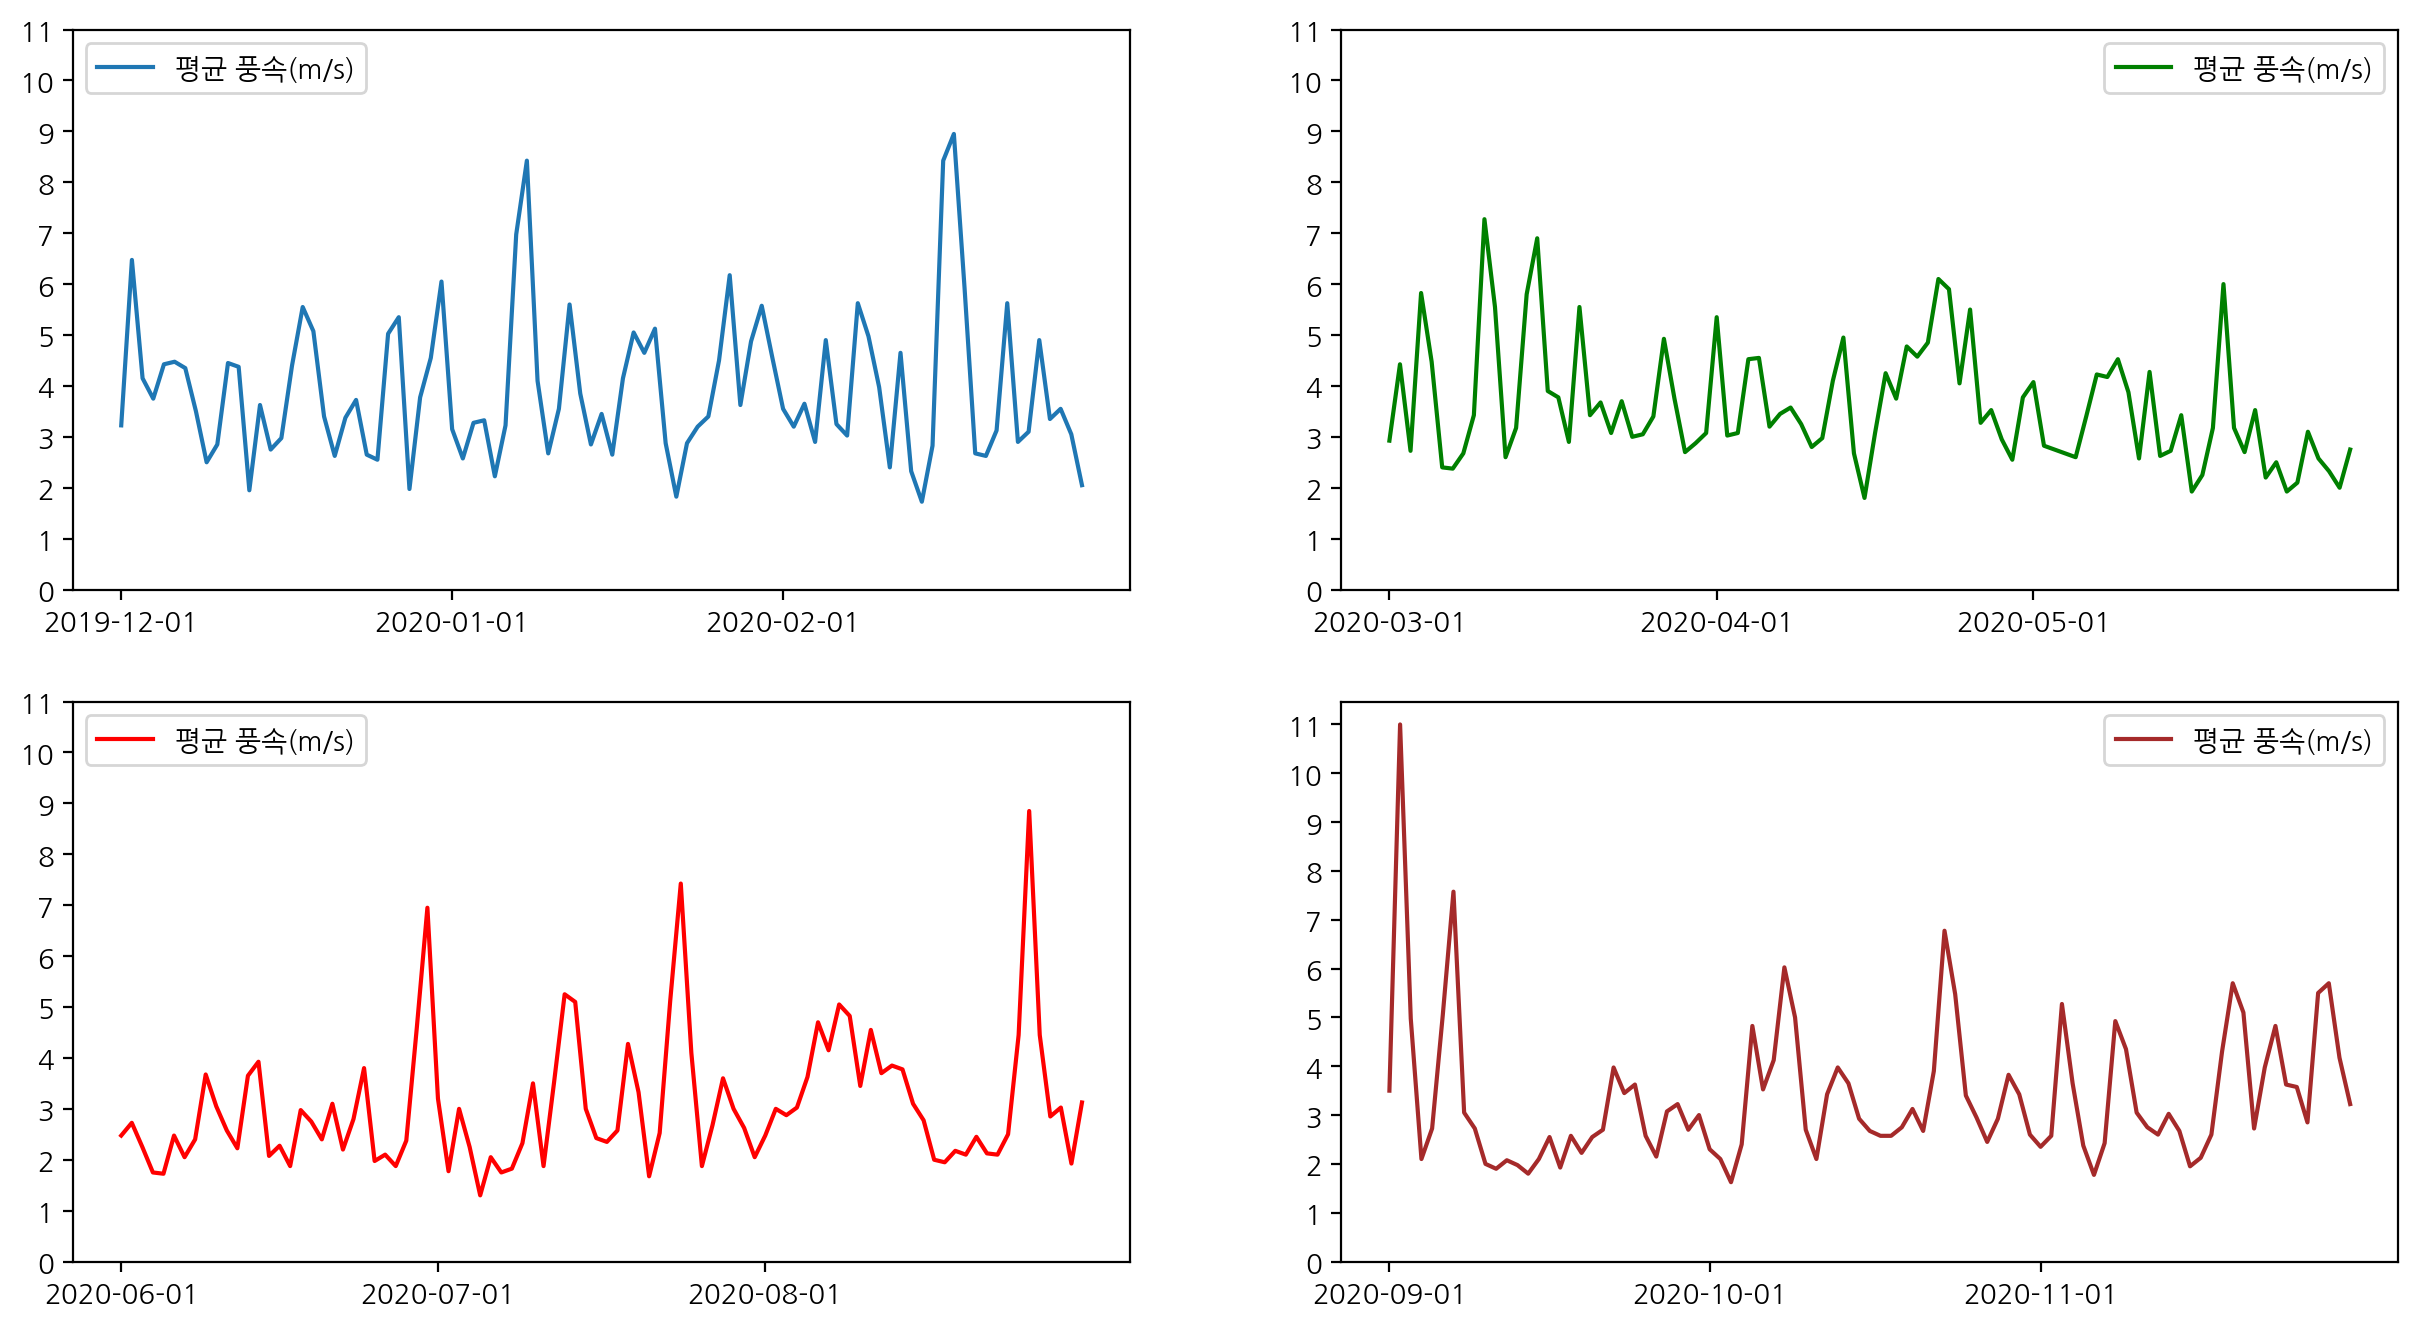

In [389]:
plt.rc('font', family='NanumGothic')

plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.plot(weather['평균 풍속(m/s)'].loc['2019-12':'2020-02'])
plt.xticks(['2019-12-01','2020-01-01','2020-02-01'])
plt.yticks(np.arange(0,12,1))
plt.legend(labels=['평균 풍속(m/s)'], bbox_to_anchor=(0.29, 0, 0, 1))
plt.subplot(2,2,2)
plt.plot(weather['평균 풍속(m/s)'].loc['2020-03':'2020-05'],c='g')
plt.xticks(['2020-03-01','2020-04-01','2020-05-01'])
plt.yticks(np.arange(0,12,1))
plt.legend(labels=['평균 풍속(m/s)'])
plt.subplot(2,2,3)
plt.plot(weather['평균 풍속(m/s)'].loc['2020-06':'2020-08'],c='r')
plt.xticks(['2020-06-01','2020-07-01','2020-08-01'])
plt.yticks(np.arange(0,12,1))
plt.legend(labels=['평균 풍속(m/s)'], bbox_to_anchor=(0.29, 0, 0, 1))
plt.subplot(2,2,4)
plt.plot(weather['평균 풍속(m/s)'].loc['2020-09':'2020-11'],c='brown')
plt.xticks(['2020-09-01','2020-10-01','2020-11-01'])
plt.yticks(np.arange(0,12,1))
plt.legend(labels=['평균 풍속(m/s)'])
plt.show()

In [390]:
import geopandas as gpd
EMD = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Project_data/Z_NGII_N3A_G0010000.shp', encoding='CP949')
geo = ['NAME','geometry']
EMD = EMD[geo]
EMD.head()

,NAME,geometry
0,강원도,"MULTIPOLYGON (((1165537.226 1907066.107, 11655..."
1,경기도,"MULTIPOLYGON (((939204.888 1885397.883, 939160..."
2,경상남도,"MULTIPOLYGON (((1053480.416 1611749.331, 10534..."
3,경상북도,"MULTIPOLYGON (((1176575.772 1741202.563, 11765..."
4,광주광역시,"POLYGON ((932713.054 1696169.622, 932794.248 1..."


In [391]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_data/한국에너지공단_풍력기 위치정보_20210630.csv', encoding='CP949')
df.head()

,단지번호,단지명,풍력기번호(임시),준공일,분류,주소,엑스좌표(GRS80_C_x),와이좌표(GRS80_C_y),위도(lat),경도(lon)
0,6,신창,1,2006-03-01,육상,제주특별자치도 제주시,83531.84942,123482.8597,33.342449,126.178046
1,6,신창,2,2006-03-01,육상,제주특별자치도 제주시,83302.14433,122768.4956,33.340327,126.170393
2,7,양양,1,2006-06-01,육상,강원도 양양군 서면 영덕리,603371.11550,331391.2646,38.020849,128.496313
3,7,양양,2,2006-06-01,육상,강원도 양양군 서면 영덕리,602963.04500,331357.0051,38.017179,128.495848
4,5,강원,1,2006-09-01,육상,강원도 평창군 대관령면 횡계리,574840.71090,350869.2915,37.760890,128.712085


In [392]:
# 포인트가 되는 풍력기 위치정보 데이터를 지도에 맞게 위치변경
C_x = []
C_y = []
for i in df['엑스좌표(GRS80_C_x)']:
  C_x.append(i+1399000)

for i in df['와이좌표(GRS80_C_y)']:
  C_y.append(i+753000)

df1 = df.copy()
df1['엑스좌표(GRS80_C_x)'] = C_x
df1['와이좌표(GRS80_C_y)'] = C_y

In [393]:
# GeoDataFrame 형식으로 변환하기
df = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(x=df1['와이좌표(GRS80_C_y)'], y=df1['엑스좌표(GRS80_C_x)']), crs="EPSG:5179")

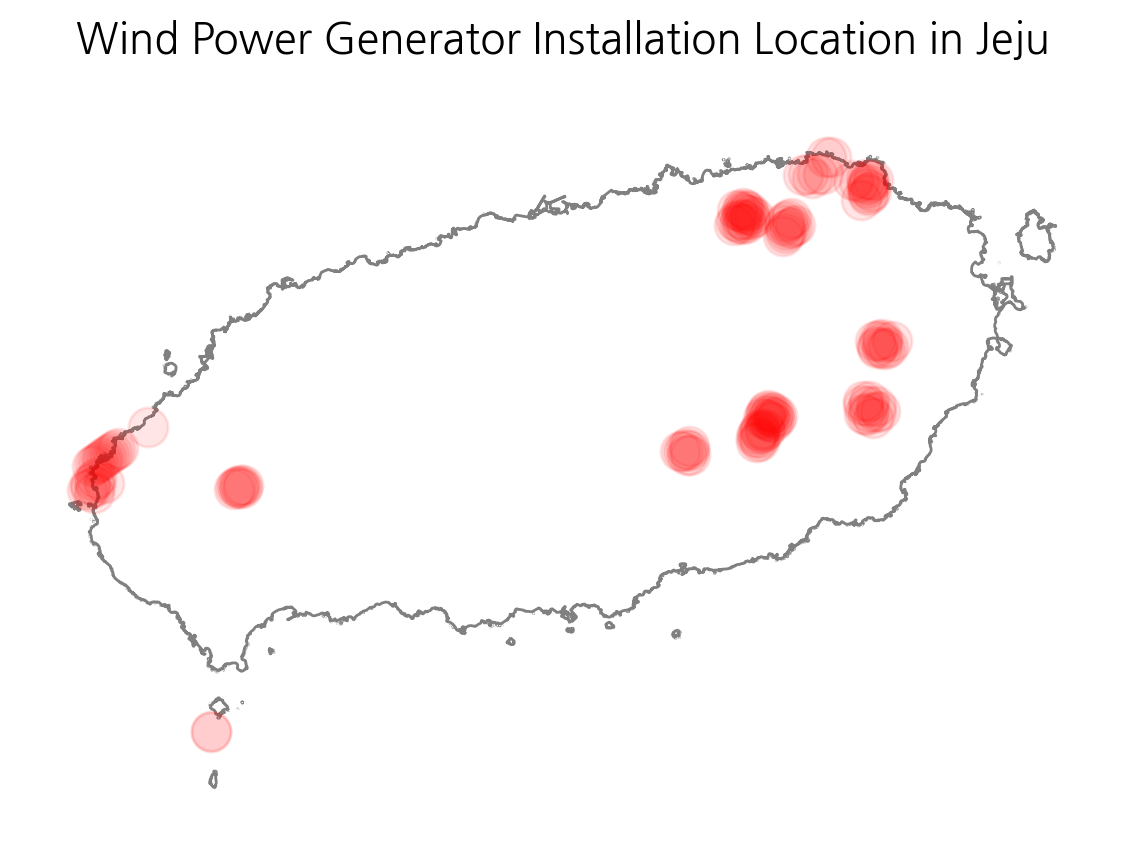

In [394]:
jeju = df[df['주소'].str[:2] == '제주']

fig, ax = plt.subplots(figsize=(7, 10))
EMD_jeju = EMD[EMD['NAME'] == '제주특별자치도']
EMD_jeju.plot(ax=ax, color='white', edgecolor="grey");
ax.set_ylim(1455000, 1515000)
points = jeju.plot(ax=ax, marker='o', color='red', markersize=200, alpha=0.1)
ax.set_axis_off()
ax.set_title('Wind Power Generator Installation Location in Jeju', fontsize=15)
plt.show()

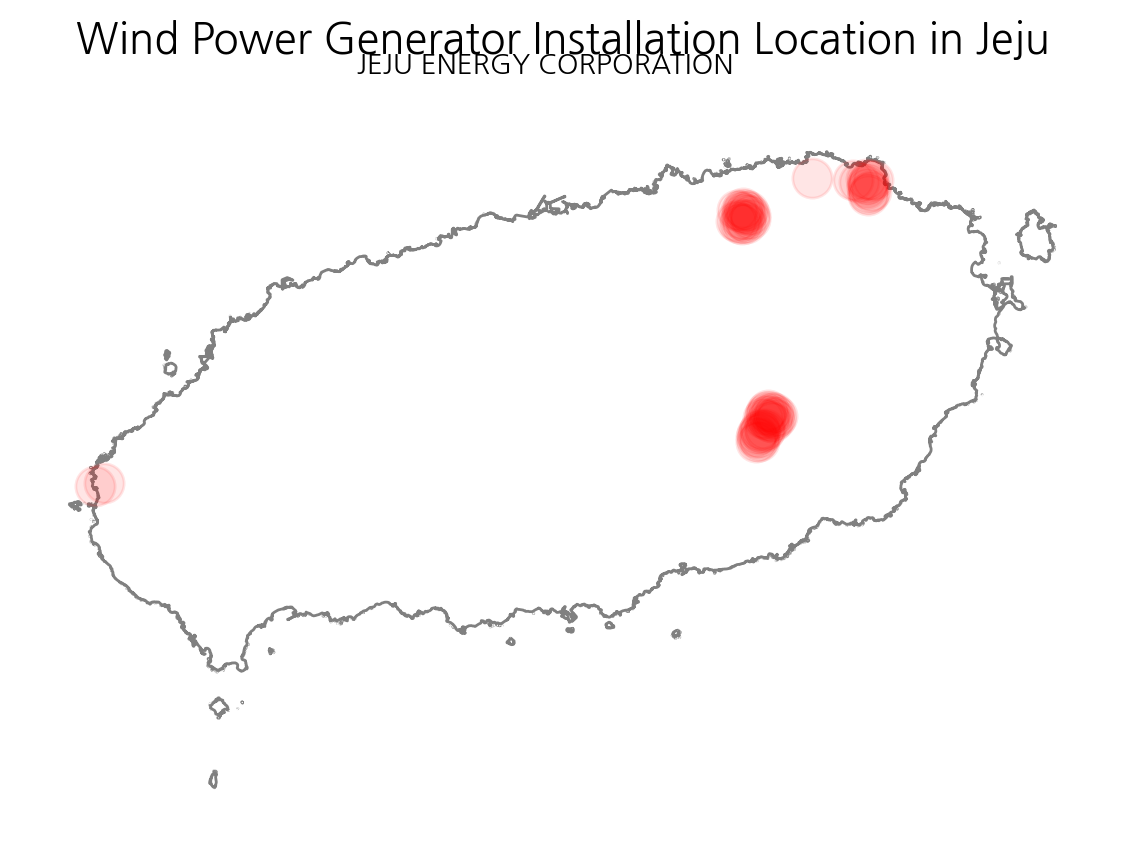

In [395]:
jeju_energy = pd.concat([jeju[jeju['단지명'].str.contains('가시리')], jeju[jeju['단지명'] == '김녕'], jeju[jeju['단지명'].str.contains('동복북촌')],
                        jeju[jeju['단지명'].str.contains('신창')], jeju[jeju['단지명'] == '행원']])

fig, ax = plt.subplots(figsize=(7, 10))
EMD_jeju = EMD[EMD['NAME'] == '제주특별자치도']
EMD_jeju.plot(ax=ax, color='white', edgecolor="grey");
ax.set_ylim(1455000, 1515000)
points = jeju_energy.plot(ax=ax, marker='o', color='red', markersize=200, alpha=0.1)
ax.set_axis_off()
ax.set_title('Wind Power Generator Installation Location in Jeju', fontsize=15)
plt.suptitle('JEJU ENERGY CORPORATION', y=0.695, fontsize=10)
plt.show()

- 계절에 따라 발전량이 다른 것을 볼 수 있다.

## 데이터 분리 및 모델선택

In [396]:
X_train = weather.loc['2018':'2020']
X_val = weather.loc['2021']
X_test = weather.loc['2022']

y_train = wind.loc['2018':'2020']
y_val = wind.loc['2021']
y_test = wind.loc['2022']

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((823, 37), (365, 37), (365, 37), (823,), (365,), (365,))

- 회귀 문제이기 때문에 Ridge Regression, Lasso Regression, Random Forest, XGBoost를 활용할 수 있다.
- 여러 가지 모델을 기본값으로 적용해 만들어 보고 적합한 모델을 찾는다.

In [397]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score

In [398]:
from sklearn.preprocessing import StandardScaler

# 특성 데이터의 표준화 진행
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [399]:
# 선형회귀 모델을 기준모델로 사용
ols = LinearRegression()

# 모델 학습
ols.fit(X_train_scaled, y_train)

print('선형회귀 모델\n훈련 데이터 r2_score :',ols.score(X_train_scaled, y_train))
print('훈련 데이터 mae :',mean_absolute_error(y_train, ols.predict(X_train_scaled)))
print('검증 데이터 r2_score :',ols.score(X_val_scaled, y_val))
print('검증 데이터 mae :',mean_absolute_error(y_val, ols.predict(X_val_scaled)))

선형회귀 모델
훈련 데이터 r2_score : 0.8459894892651734
훈련 데이터 mae : 71929.72631867218
검증 데이터 r2_score : 0.39370814462247816
검증 데이터 mae : 100397.65999479171


In [400]:
from sklearn.linear_model import RidgeCV

# ridgecv로 학습
alphas = np.arange(50, 200, 1)
ridge = RidgeCV(alphas=alphas, cv=5)
ridge.fit(X_train_scaled, y_train)

print("Ridge alpha: ", ridge.alpha_)

print('훈련 데이터 r2_score :',ridge.score(X_train_scaled, y_train))
print('훈련 데이터 mae :',mean_absolute_error(y_train, ridge.predict(X_train_scaled)))
print('검증 데이터 r2_score :',ridge.score(X_val_scaled, y_val))
print('검증 데이터 mae :',mean_absolute_error(y_val, ridge.predict(X_val_scaled)))

Ridge alpha:  50
훈련 데이터 r2_score : 0.8247924969745685
훈련 데이터 mae : 75419.91682174556
검증 데이터 r2_score : 0.7679383189523402
검증 데이터 mae : 87073.15068765136


In [401]:
from sklearn.linear_model import LassoCV
import warnings
warnings.filterwarnings('ignore')

# lassocv로 학습
alphas = np.arange(100, 200, 1)
lasso = LassoCV(alphas=alphas, cv=5, random_state=42)
lasso.fit(X_train_scaled, y_train)

print("Lasso alpha: ", lasso.alpha_)

print('훈련 데이터 r2_score :',lasso.score(X_train_scaled, y_train))
print('훈련 데이터 mae :',mean_absolute_error(y_train, lasso.predict(X_train_scaled)))
print('검증 데이터 r2_score :',lasso.score(X_val_scaled, y_val))
print('검증 데이터 mae :',mean_absolute_error(y_val, lasso.predict(X_val_scaled)))

Lasso alpha:  199
훈련 데이터 r2_score : 0.844117555193759
훈련 데이터 mae : 71677.40327511361
검증 데이터 r2_score : 0.7483976793541322
검증 데이터 mae : 87452.3480925501


In [402]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(random_state=42, oob_score=True, n_jobs=-1)
model_rf.fit(X_train_scaled, y_train)

print('RandomForest\n훈련 데이터 r2_score :',model_rf.score(X_train_scaled, y_train))
print('훈련 데이터 mae :',mean_absolute_error(y_train, model_rf.predict(X_train_scaled)))
print('검증 데이터 r2_score :',model_rf.score(X_val_scaled, y_val))
print('검증 데이터 mae :',mean_absolute_error(y_val, model_rf.predict(X_val_scaled)))

RandomForest
훈련 데이터 r2_score : 0.9821024617522223
훈련 데이터 mae : 23580.7965400729
검증 데이터 r2_score : 0.7885914543224655
검증 데이터 mae : 78499.59294663013


In [403]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(random_state=42, n_jobs=-1)
model_xgb.fit(X_train_scaled, y_train)

print('XGBoost\n훈련 데이터 r2_score :',model_xgb.score(X_train_scaled, y_train))
print('훈련 데이터 mae :',mean_absolute_error(y_train, model_xgb.predict(X_train_scaled)))
print('검증 데이터 r2_score :',model_xgb.score(X_val_scaled, y_val))
print('검증 데이터 mae :',mean_absolute_error(y_val, model_xgb.predict(X_val_scaled)))

XGBoost
훈련 데이터 r2_score : 0.9999914551837408
훈련 데이터 mae : 497.6482246767139
검증 데이터 r2_score : 0.7821699020464008
검증 데이터 mae : 79617.01899031464


- 여러 모델을 비교한 결과, Random Forest와 XGBoost 모델이 과적합이 일어나긴 했지만 정확도가 비교적 높은 것으로 보인다.
- Random Forest와 XGBoost의 하이러파라미터를 조정해 둘 중 더 적합한 모델을 찾아 평가데이터를 적용해 볼 것이다.(RandomizedSearchCV와 GridSearchCV를 활용)
- 과적합을 줄이기 위해 훈련데이터의 스코어를 의도적으로 낮춰야 될 것으로 보인다.

---
- RandomForest

In [404]:
from sklearn.model_selection import RandomizedSearchCV

# 매개변수 선언
params_rf = {
    "max_depth": np.arange(3, 10, 1),
    "n_estimators": np.arange(10, 100, 10),
    "min_samples_split": np.arange(1, 50, 1),
}

# 기본 모델
model_rf = RandomForestRegressor(random_state=42, oob_score=True, n_jobs=-1)

# RandomizedCV 모델
randomcv_rf = RandomizedSearchCV(model_rf, params_rf, scoring='r2', n_iter=10, cv=3, random_state=42)

# 학습
randomcv_rf.fit(X_train_scaled, y_train)

print('최적 하이퍼파라미터:', randomcv_rf.best_params_,'\n')

print('훈련 데이터 r2_score :',randomcv_rf.score(X_train_scaled, y_train))
print('훈련 데이터 mae :',mean_absolute_error(y_train, randomcv_rf.predict(X_train_scaled)),'\n')

print('검증 데이터 r2_score :',randomcv_rf.score(X_val_scaled, y_val))
print('검증 데이터 mae :',mean_absolute_error(y_val, randomcv_rf.predict(X_val_scaled)))

최적 하이퍼파라미터: {'n_estimators': 70, 'min_samples_split': 18, 'max_depth': 6} 

훈련 데이터 r2_score : 0.932802450121715
훈련 데이터 mae : 47943.95091206719 

검증 데이터 r2_score : 0.7884272549646532
검증 데이터 mae : 78731.59973055549


In [405]:
from sklearn.model_selection import GridSearchCV

# 매개변수 선언
params_rf = {
    "max_depth": np.arange(3, 5, 1),
    "n_estimators": np.arange(40, 60, 5),
    "min_samples_split": np.arange(5, 12, 1),
}

# GridSearchCV 모델
grid_rf = GridSearchCV(model_rf, params_rf, scoring='r2', cv=3)

# 학습
grid_rf.fit(X_train_scaled, y_train)

print('최적 하이퍼파라미터:', grid_rf.best_params_,'\n')

print('훈련 데이터 r2_score :',grid_rf.score(X_train_scaled, y_train))
print('훈련 데이터 mae :',mean_absolute_error(y_train, grid_rf.predict(X_train_scaled)),'\n')

print('검증 데이터 r2_score :',grid_rf.score(X_val_scaled, y_val))
print('검증 데이터 mae :',mean_absolute_error(y_val, grid_rf.predict(X_val_scaled)))

최적 하이퍼파라미터: {'max_depth': 4, 'min_samples_split': 11, 'n_estimators': 40} 

훈련 데이터 r2_score : 0.9036372643789811
훈련 데이터 mae : 57305.613503438595 

검증 데이터 r2_score : 0.7793586651034858
검증 데이터 mae : 80453.94602383935


---
- XGBoost

In [406]:
# 매개변수 선언
params_xgb = {
    "max_depth": np.arange(3, 8, 1),
    "learning_rate": np.arange(0.05, 0.1, 0.01),
    "n_estimators": np.arange(70, 100, 1)
}

# 기본 모델
model_xgb = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# RandomizedCV 모델
randomcv_xgb = RandomizedSearchCV(model_xgb, params_xgb, scoring='r2', n_iter=10, cv=3, random_state=42)

# 학습
randomcv_xgb.fit(X_train_scaled, y_train)

print('최적 하이퍼파라미터:', randomcv_xgb.best_params_,'\n')

print('훈련 데이터 r2_score :',randomcv_xgb.score(X_train_scaled, y_train))
print('훈련 데이터 mae :',mean_absolute_error(y_train, randomcv_xgb.predict(X_train_scaled)),'\n')

print('검증 데이터 r2_score :',randomcv_xgb.score(X_val_scaled, y_val))
print('검증 데이터 mae :',mean_absolute_error(y_val, randomcv_xgb.predict(X_val_scaled)))

최적 하이퍼파라미터: {'n_estimators': 76, 'max_depth': 4, 'learning_rate': 0.07} 

훈련 데이터 r2_score : 0.9650109309682942
훈련 데이터 mae : 35039.04812670869 

검증 데이터 r2_score : 0.7994295420896691
검증 데이터 mae : 75504.72417551371


In [407]:
# 매개변수 선언
params_xgb = {
    "max_depth": [3, 4, 5],
    "learning_rate": np.arange(0.02, 0.07, 0.01),
    "n_estimators": np.arange(55, 70, 1)
}

# GridSearchCV 모델
gridcv_xgb = GridSearchCV(model_xgb, params_xgb, scoring='r2', cv=3)

# 학습
gridcv_xgb.fit(X_train_scaled, y_train)

print('최적 하이퍼파라미터:', gridcv_xgb.best_params_,'\n')

print('훈련 데이터 r2_score :',gridcv_xgb.score(X_train_scaled, y_train))
print('훈련 데이터 mae :',mean_absolute_error(y_train, gridcv_xgb.predict(X_train_scaled)),'\n')

print('검증 데이터 r2_score :',gridcv_xgb.score(X_val_scaled, y_val))
print('검증 데이터 mae :',mean_absolute_error(y_val, gridcv_xgb.predict(X_val_scaled)))

최적 하이퍼파라미터: {'learning_rate': 0.06, 'max_depth': 4, 'n_estimators': 65} 

훈련 데이터 r2_score : 0.95377428828073
훈련 데이터 mae : 40193.35248663426 

검증 데이터 r2_score : 0.8104134863260376
검증 데이터 mae : 73704.10040068493


> - RandomForest<br>
훈련 데이터 r2_score : 0.9437957797067928<br>
훈련 데이터 mae : 44559.16630244552<br>
검증 데이터 r2_score : 0.783659029214315<br>
검증 데이터 mae : 79997.34661339577
- XGBoost<br>
훈련 데이터 r2_score : 0.9300471405617375<br>
훈련 데이터 mae : 48341.50225303767<br>
검증 데이터 r2_score : 0.8114848603668103<br>
검증 데이터 mae : 73388.52311001712

두 모델의 평가지표를 비교해 봤을 때, XGBoost의 결과가 미세하게 조금 더 좋게 나온 것을 볼 수 있었다.<br>
XGBoost를 사용해 불필요한 특성을 버리고 하이퍼파라미터를 조정해 더 좋은 스코어가 나오도록 한다.

## XGBoost 모델링

In [409]:
model_xgb = XGBRegressor(random_state=42, n_jobs=-1, learning_rate=0.06, max_depth=3, n_estimators=69)
model_xgb.fit(X_train_scaled, y_train)
print('훈련 데이터 r2_score :',model_xgb.score(X_train_scaled, y_train))
print('훈련 데이터 mae :',mean_absolute_error(y_train, model_xgb.predict(X_train_scaled)),'\n')

print('검증 데이터 r2_score :',model_xgb.score(X_val_scaled, y_val))
print('검증 데이터 mae :',mean_absolute_error(y_val, model_xgb.predict(X_val_scaled)))

훈련 데이터 r2_score : 0.9310410010597757
훈련 데이터 mae : 48328.30242134341 

검증 데이터 r2_score : 0.8105884208006995
검증 데이터 mae : 73911.3262333048


Before Drop :: 검증 정확도 0.931041
Drop 평균기온(°C) :: 검증 정확도 0.931056
Drop 최저기온(°C) :: 검증 정확도 0.931702
Drop 최고기온(°C) :: 검증 정확도 0.931175
Drop 강수 계속시간(hr) :: 검증 정확도 0.931041
Drop 10분 최다 강수량(mm) :: 검증 정확도 0.931736
Drop 1시간 최다강수량(mm) :: 검증 정확도 0.931041
Drop 일강수량(mm) :: 검증 정확도 0.931004
Drop 최대 순간 풍속(m/s) :: 검증 정확도 0.930348
Drop 최대 순간 풍속 풍향(16방위) :: 검증 정확도 0.931084
Drop 최대 풍속(m/s) :: 검증 정확도 0.931320
Drop 최대 풍속 풍향(16방위) :: 검증 정확도 0.929793
Drop 평균 풍속(m/s) :: 검증 정확도 0.931088
Drop 풍정합(100m) :: 검증 정확도 0.930117
Drop 평균 이슬점온도(°C) :: 검증 정확도 0.931409
Drop 최소 상대습도(%) :: 검증 정확도 0.931609
Drop 평균 상대습도(%) :: 검증 정확도 0.931527
Drop 평균 증기압(hPa) :: 검증 정확도 0.931764
Drop 평균 현지기압(hPa) :: 검증 정확도 0.931041
Drop 최고 해면기압(hPa) :: 검증 정확도 0.930743
Drop 최저 해면기압(hPa) :: 검증 정확도 0.930923
Drop 평균 해면기압(hPa) :: 검증 정확도 0.931041
Drop 가조시간(hr) :: 검증 정확도 0.931565
Drop 합계 일조시간(hr) :: 검증 정확도 0.930899
Drop 1시간 최다일사량(MJ/m2) :: 검증 정확도 0.931484
Drop 합계 일사량(MJ/m2) :: 검증 정확도 0.931240
Drop 일 최심신적설(cm) :: 검증 정확도 0.931041
Drop 일 최심적설(cm) :: 검증 정확도 

Text(0.5, 1.0, 'Drop-Column Importance')

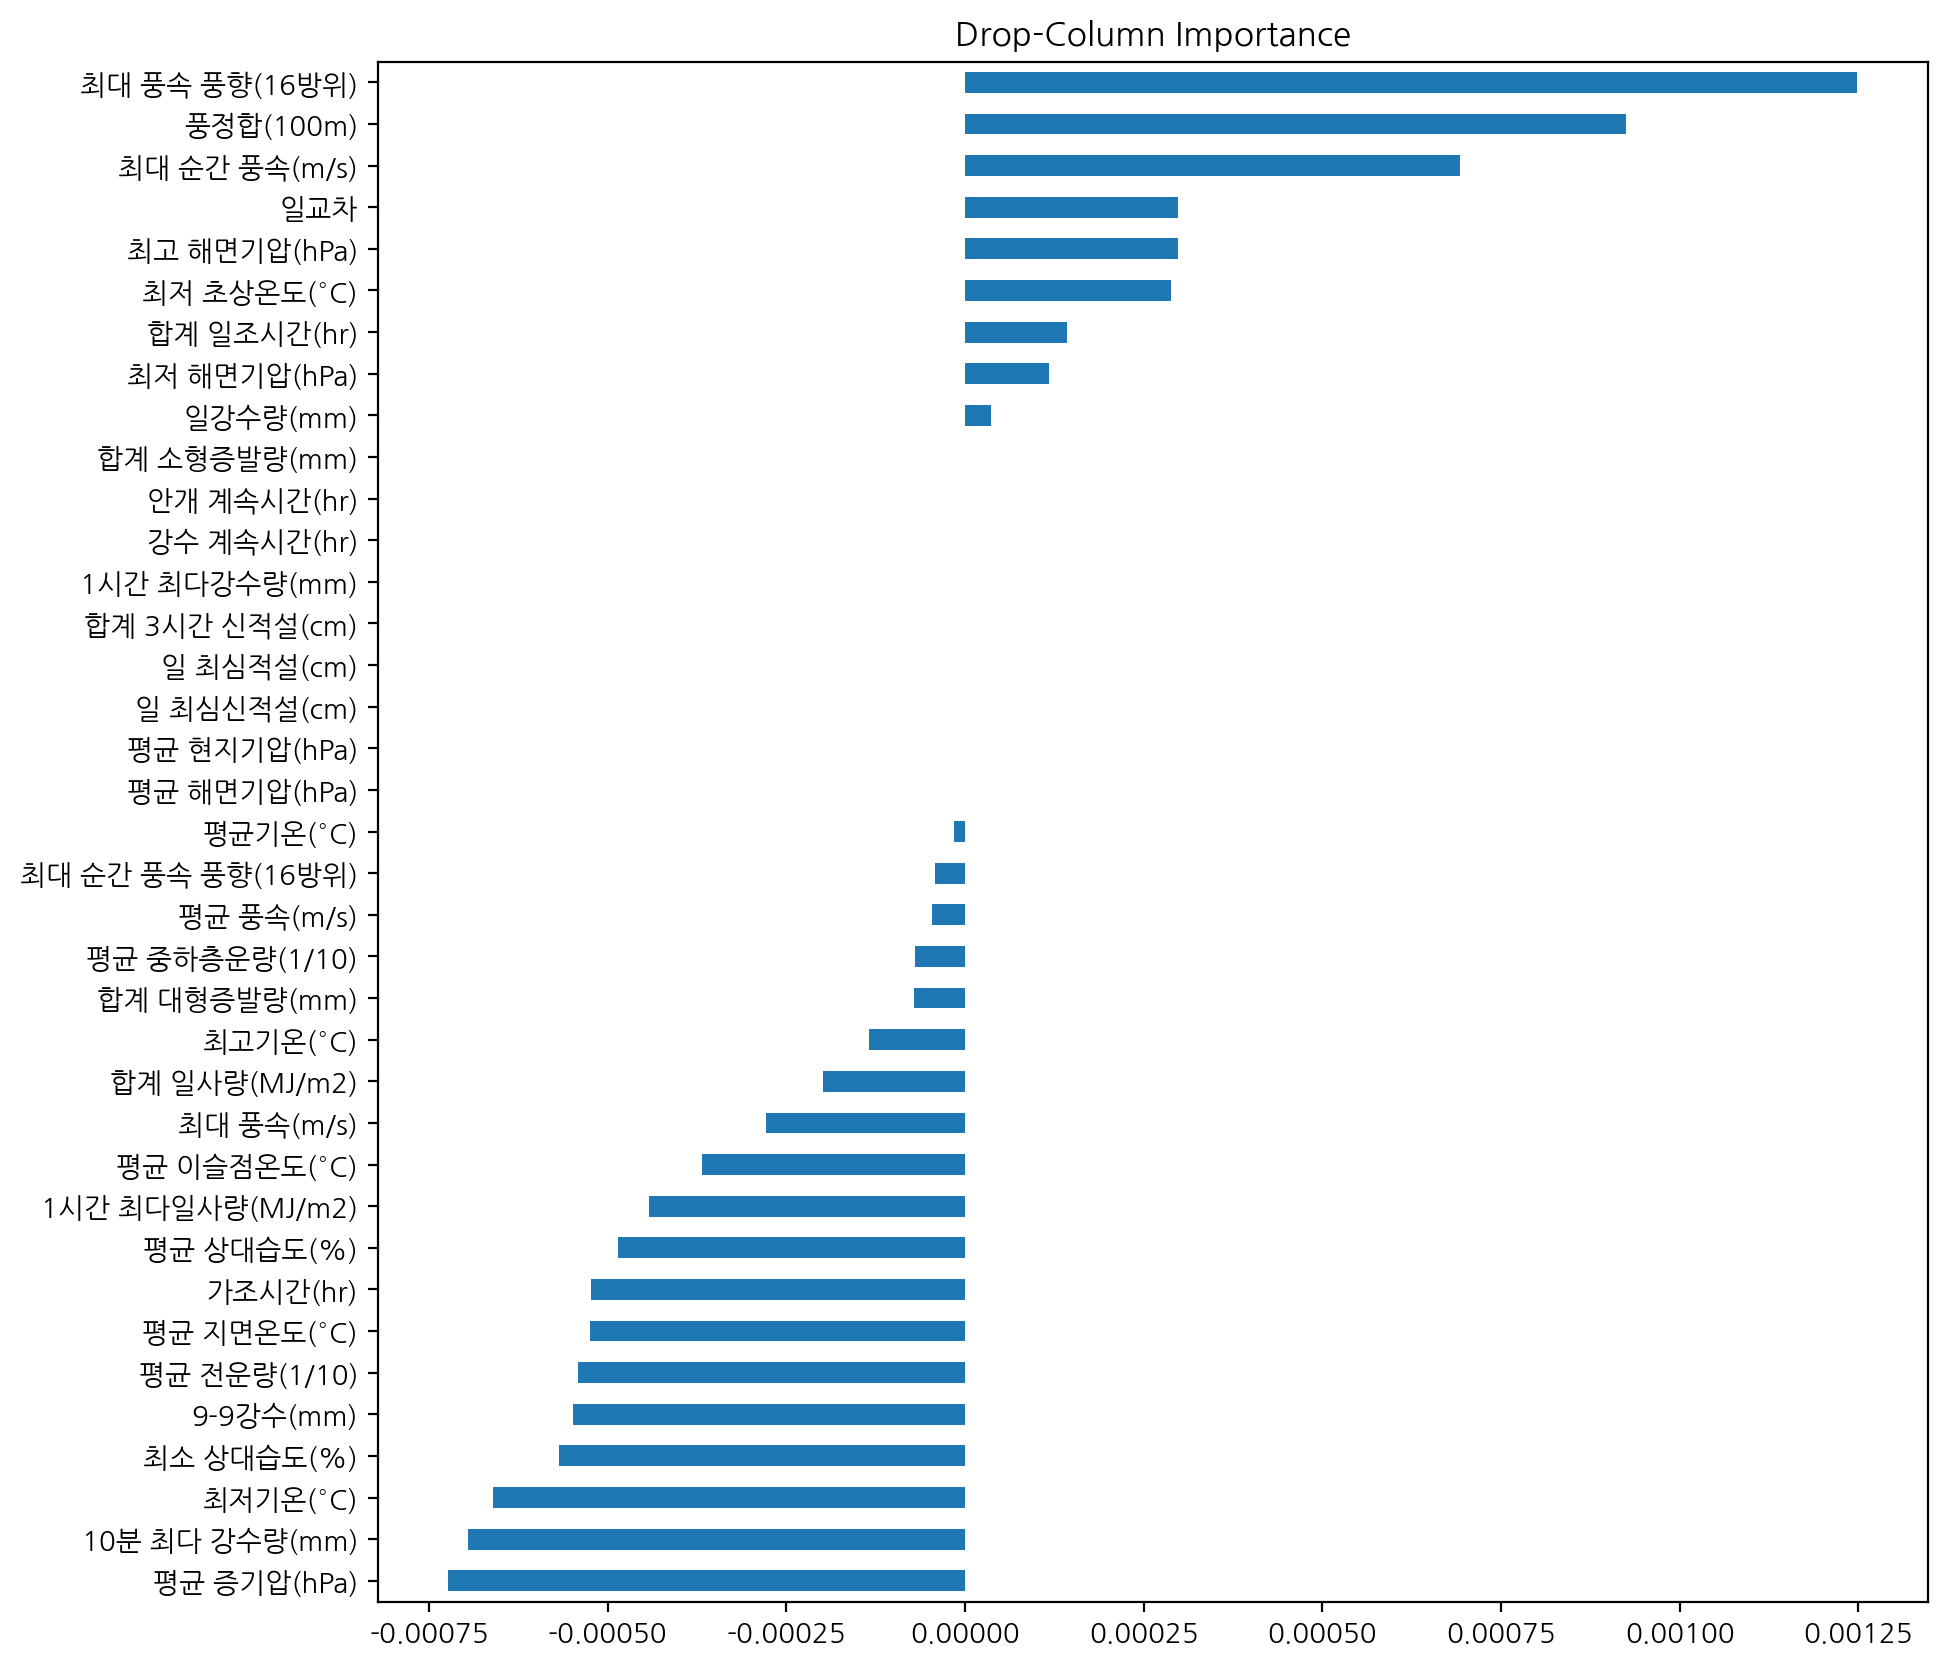

In [223]:
# 모든 column을 사용해 학습했을 때의 검증 정확도
score = model_xgb.score(X_train_scaled, y_train)
print(f'Before Drop :: 검증 정확도 {score:.6f}')
dci = pd.Series(dtype=float)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns.tolist())
# for문을 활용하여 각 feature를 drop한 경우의 검증 정확도를 확인한다.

features = X_train.columns
for feature in features:

    # feature을 drop하여 모델을 재학습합니다.
    model_xgb.fit(X_train_scaled_df.drop(columns=[feature], axis=1), y_train)
    score_dropped = model_xgb.score(X_train_scaled_df.drop(columns=[feature], axis=1), y_train)
    print(f"Drop {feature} :: 검증 정확도 {score_dropped:.6f}")

    # drop-column importance는 해당 특성을 drop했을 때의 성능 하락폭으로 정의됩니다.
    dci[feature] = score - score_dropped


# 마이너스 깨짐현상 해결
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

# matplotlib 폰트설정
plt.rc('font', family='NanumGothic') # For Windows
# print(plt.rcParams['font.family'])

# 시각화
%matplotlib inline
plt.figure(figsize=(10,10))
dci.sort_values().plot.barh()
plt.title("Drop-Column Importance")

In [250]:
drop_features = dci[dci <= 0].index
X_train_dropped = X_train.drop(drop_features, axis=1)
X_train_dropscaled = scaler.fit_transform(X_train_dropped)
X_val_dropped = X_val.drop(drop_features, axis=1)
X_val_dropscaled = scaler.transform(X_val_dropped)
X_test_dropped = X_test.drop(drop_features, axis=1)
X_test_dropscaled = scaler.transform(X_test_dropped)

In [251]:
# 매개변수 선언
params_xgb = {
    "max_depth": [4, 5, 6],
    "learning_rate": np.arange(0.02, 0.04, 0.01),
    "n_estimators": np.arange(55, 63, 1)
}

# GridSearchCV 모델
gridcv_xgb = GridSearchCV(model_xgb, params_xgb, scoring='r2', cv=3)

# 학습
gridcv_xgb.fit(X_train_dropscaled, y_train)

print('최적 하이퍼파라미터:', gridcv_xgb.best_params_,'\n')

print('훈련 데이터 r2_score :',gridcv_xgb.score(X_train_dropscaled, y_train))
print('훈련 데이터 mae :',mean_absolute_error(y_train, gridcv_xgb.predict(X_train_dropscaled)),'\n')

print('검증 데이터 r2_score :',gridcv_xgb.score(X_val_dropscaled, y_val))
print('검증 데이터 mae :',mean_absolute_error(y_val, gridcv_xgb.predict(X_val_dropscaled)))

최적 하이퍼파라미터: {'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 62} 

훈련 데이터 r2_score : 0.8651426306929804
훈련 데이터 mae : 65224.71671326321 

검증 데이터 r2_score : 0.8390728495870806
검증 데이터 mae : 68996.08711494008


In [308]:
# 모델 최종 학습
model_xgb = XGBRegressor(random_state=42, n_jobs=-1, learning_rate=0.03, max_depth=4, n_estimators=62)
model_xgb.fit(X_train_dropscaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=62, n_jobs=-1, num_parallel_tree=None, predictor=None,
             random_state=42, ...)

- Permutation Importance는 강한 상관관계가 있는 특성들이 존재할 때, 잘못된 값을 낼 수 있기 때문에 날씨 데이터에 적용하기에 적절하지 않다고 판단하였다.
- 따라서, 항목을 하나씩 삭제해보는 Drop-Column Importance로 특성 중요도를 파악하여 중요도가 0이하인 것들을 삭제하였다.

---
> - drop 전 데이터에 대한 검증지표<br>
훈련 데이터 r2_score : 0.9307423980235184<br>
훈련 데이터 mae : 48142.87841912211<br>
검증 데이터 r2_score : 0.8114454030798849<br>
검증 데이터 mae : 73370.88653681507
- drop 후 하이퍼파라미터 적용 모델에 대한 검증지표<br>
훈련 데이터 r2_score : 0.8420655944220414<br>
훈련 데이터 mae : 70860.62089747873<br>
검증 데이터 r2_score : 0.8264240724888211<br>
검증 데이터 mae : 71427.63995077055<br>

- 삭제하고 남은 특성들만 모델에 학습시킨 결과, 검증지표가 미세하지만 좋아진 것으로 보인다.

## 평가 데이터 적용

In [255]:
print('훈련 데이터 r2_score :',model_xgb.score(X_train_dropscaled, y_train))
print('훈련 데이터 mae :',mean_absolute_error(y_train, model_xgb.predict(X_train_dropscaled)),'\n')
# 검증 데이터
print('검증 데이터 r2_score :',model_xgb.score(X_val_dropscaled, y_val))
print('검증 데이터 mae :',mean_absolute_error(y_val, model_xgb.predict(X_val_dropscaled)),'\n')
# 평가 데이터
print('평가 데이터 r2_score :',model_xgb.score(X_test_dropscaled, y_test))
print('평가 데이터 mae :',mean_absolute_error(y_test, model_xgb.predict(X_test_dropscaled)))

훈련 데이터 r2_score : 0.8651426306929804
훈련 데이터 mae : 65224.71671326321 

검증 데이터 r2_score : 0.8390728495870806
검증 데이터 mae : 68996.08711494008 

평가 데이터 r2_score : 0.8063727532491776
평가 데이터 mae : 70472.58206472603


In [369]:
final = pd.DataFrame(model_xgb.predict(X_test_dropscaled), y_test).reset_index()
final['값차이'] = np.abs(model_xgb.predict(X_test_dropscaled) - y_test).round(3).tolist()
final = final.rename(columns={'전체':'실제값',0:'예측값'})
final

,실제값,예측값,값차이
0,190443.180,175393.250000,15049.930
1,267382.380,256650.750000,10731.630
2,261493.740,233173.609375,28320.131
3,343960.380,256650.750000,87309.630
4,147205.620,169113.734375,21908.114
...,...,...,...
360,507640.942,389050.250000,118590.692
361,465988.173,482147.812500,16159.639
362,325897.035,389050.250000,63153.215
363,228959.462,299558.593750,70599.132


- 과적합 방지를 위해 하이퍼파라미터를 조정하여 과도한 학습을 막았더니 훈련데이터의 지표는 나빠졌지만 검증데이터의 지표는 좋아졌다.
- 이것을 훈련데이터에 적용하였더니 검증지표와 비슷한 수준의 검증지표 결과가 나왔다.

---
- 일 단위의 풍력발전 데이터가 많지 않아 학습이 충분히 이루어지지 않았을 때는 지표 결과가 좋지 않았으나 조금씩 최대한 데이터를 추가해주자 수치가 점차 좋아지는 것을 볼 수 있었다.